# Brain decoding with MLP

This part of the `session` aims to make `participants` familiar with [Multilayer Peceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron) as one possible `decoding model` that can be applied to `brain data`. The objectives 📍 are:

- get to know the basics of `Multilayer Peceptrons`

    - `model` creation
    - `model` `training` 
    - `model` `testing`


## Multilayer Perceptron
```{figure} mlp_decoding/multilayer-perceptron.png
---
width: 800px
name: multilayer-perceptron-fig
---
A multilayer perceptron with 25 units on the input layer, a single hidden layer with 17 units, and an output layer with 9 units. Figure generated with the [NN-SVG](http://alexlenail.me/NN-SVG/index.html) tool by [Alexander Lenail]. The figure is shared under a [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.
```
We are going to train a `Multilayer Perceptron` (`MLP`) `classifier` for `brain decoding` on the [Haxby dataset](https://main-educational.github.io/brain_encoding_decoding/haxby_data.html). `MLP`s are one of the most basic architecture of [artificial neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). As such, `MLP`s consist of `input` and `output` `layers` as well as `hidden layers` that process the `input` through a succession of `transformations` towards the `output layer` that performs the task at hand, e.g. a `classification` or `regression`. Like other `machine learning models` for `supervised learning`, an `MLP` initially goes through a `training phase`. During this `supervised phase`, the `network` is taught what to look for and what is the desired output via its `objective function`. This refers to, minimizing the `loss`, ie the deviation of `predictions` from the "ground truth", and thus increasing its performance.

`MLP`s were actually among the first `ANN`s to appear, specifically the [Mark I Peceptron](https://en.wikipedia.org/wiki/Perceptron) which you can see below.

```{figure} https://preview.redd.it/wgzps0pvcny91.jpg?width=640&crop=smart&auto=webp&s=0b2e56dc4eaa886ebd01ac0cd8e51fc4efdb1d01
---
width: 400px
name: markI-perceptron-fig
---
Frank Rosenblatt with a Mark I Perceptron computer in 1960.
```


In this tutorial, we are going to train the simplest `MLP` architecture featuring one `input layer`, one `output layer` and just one `hidden layer`.

## Getting the data

We are going to work with the Haxby dataset {cite:p}`Haxby2001-vt` again. You can check the section {ref}`haxby-dataset` for more details on that `dataset`. Here we are going to quickly `download` and prepare it for `machine learning applications` with a set of `predictive variables`, the `brain time series` `X`, and a `dependent variable`, the respective `cognitive processes`/`function`/`percepts` `y`.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/nilearn/datasets/func.py:20: DeprecationWarning: Please use `MatReadError` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.miobase` namespace is deprecated.
  from scipy.io.matlab.miobase import MatReadError
/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


As an initial check, we'll have a look at the size of `X` and `y`:

In [2]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


So we have `1452` `time points`, with one `label` for the respective `stimulus percept` each, and for each `time point` we have `recordings` of `brain` activity obtained via  `fMRI` across `675 voxels` (within the `VT` `mask`). We can also see that the `stimulus percept`s span `9` different `categories`.

However, concerning our planned analyses, we need to convert our `categories` into a [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [3]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
enc = OneHotEncoder(handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1))
# turn the sparse matrix into a pandas dataframe
y = pd.DataFrame(y_onehot.toarray())
display(y)

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1447,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Training a model

As introduced in the prior `tutorials`, one of the most important aspects of `machine learning` is the split between `train` and `tests`. `MLP`s are no exception to that and thus we need to split our dataset accordingly. We will keep `20%` of the `time points` as `test`, and then set up a `10 fold cross validation` for `training/validation`.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

With that, we can already build our `MLP`. Here, we are going to use [Tensorflow](https://www.tensorflow.org/) and [Keras](https://keras.io/). As with every other `ANN`, we need to `import` the respective components, here, the `model` and `layer` `type`. In our case we will use a [`Sequential` `model`](https://keras.io/guides/sequential_model/) and [`Dense`](https://keras.io/api/layers/core_layers/dense/) `layers`.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

2022-12-09 20:51:55.403353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 20:51:55.403390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:28: DeprecationWarning: HAMMING is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

`````{admonition} A note regarding our MLP
:class: tip
Please note that the example `MLP` we are going to `create` and `train` here is rather simple as we want to enable its application on machines with rather limited computational resources (ie your laptops or binder). "Real-world" models are usually more complex and might also entail different `types` and `layers`.
`````

Initially, we need to create our, so far, `empty model`.

In [6]:
# number of unique conditions that we have
model_mlp = Sequential()

2022-12-09 20:51:56.916155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-09 20:51:56.916188: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 20:51:56.916217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az167-841): /proc/driver/nvidia/version does not exist
2022-12-09 20:51:56.916517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we can add the `layers` to our `model`, starting with the `input layer`. Given this is a rather short introduction to the topic and does not focus on `ANN`s, we are going to set the `kernel initialization` and `activation function` to appropriate defaults (Please have a look at the [Introduction to deep learning session](https://main-educational.github.io/material.html#introduction-to-deep-learning-using-pytorch) for more information.).

In [7]:
model_mlp.add(Dense(50 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

As noted above, we are using `Dense` `layers` and as you can see, we set the `input dimensions` to `675`. You might have already notices that this is the number of `voxels` we have `data` from. Setting the `input dimension` according to the `data dimensions` is rather important is referred to as the [semantic gap](https://en.wikipedia.org/wiki/Semantic_gap): the transformation of `actions` & `percepts` conducted/perceived by `human`s into `computational representations`. For example, pictures are "nothing" but a huge `array` for a computer and what will be submitted to the input layer of an `ANN` (note: this also holds true for basically any other type of `data`). Here, our `MLP` receives the extracted `brain activity patterns` as `input` which are already in the right `array` format thanks to `nilearn`. Thus, always carefully think about what your `input` `data` entails and how it is structured to then setup your `input layer` accordingly.

Next, we are going to add one `hidden layer`.

In [8]:
model_mlp.add(Dense(30, kernel_initializer="uniform", activation = 'relu'))

And because we are creating a very simple `MLP` with only three `layers`, we already add our `output layer`, using the `softmax` `activation function` given that we aim to `train` our `MLP` to `predict` the different `categories` that were perceived by the `participants` from their `brain activity patterns`.

In [9]:
model_mlp.add(Dense(len(categories), activation = 'softmax'))

To get a nice overview of our `ANN`, we can now use the `.summary()` `function`, which will provide us with the `model type`, `model parameters` and for each `layer`, the its `type`, `shape` and `parameters`.

In [10]:
model_mlp.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 50)                33800     


 dense_1 (Dense)             (None, 30)                1530      


 dense_2 (Dense)             (None, 9)                 279       


Total params: 35,609


Trainable params: 35,609


Non-trainable params: 0


_________________________________________________________________


With that, we already created our `MLP` `architecture`, which is now ready to be `compiled`! Within this step, we will set the `optimizer`, `loss function` and `metric`, ie `components` that define how our `MLP` will `learn`.

In [11]:
model_mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Now it's to `train` our `MLP`. Thus, we have to `fit` it to our `data`, specifically only the `training` `data`. Here, we are going to provide a few more `hyperparameters` that will define how our `MLP` is going to `learn`. This entails the `batch size`, the `epochs` and `split` of `validation sets`. We will assign the respective output to a variable so that we can investigate our `MLP`'s `learning process`.

In [12]:
history = model_mlp.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

Epoch 1/10


 1/93 [..............................] - ETA: 38s - loss: 2.2402 - accuracy: 0.1000

36/93 [==========>...................] - ETA: 0s - loss: 2.0244 - accuracy: 0.3472 

74/93 [======================>.......] - ETA: 0s - loss: 1.7611 - accuracy: 0.4297

93/93 [==============================] - 1s 3ms/step - loss: 1.7062 - accuracy: 0.4472 - val_loss: 1.4414 - val_accuracy: 0.5064


Epoch 2/10


 1/93 [..............................] - ETA: 0s - loss: 1.4880 - accuracy: 0.5000

41/93 [============>.................] - ETA: 0s - loss: 1.1750 - accuracy: 0.6268

79/93 [========================>.....] - ETA: 0s - loss: 1.0950 - accuracy: 0.6418

93/93 [==============================] - 0s 2ms/step - loss: 1.0816 - accuracy: 0.6487 - val_loss: 1.1332 - val_accuracy: 0.6352


Epoch 3/10


 1/93 [..............................] - ETA: 0s - loss: 0.6871 - accuracy: 0.9000

42/93 [============>.................] - ETA: 0s - loss: 0.7616 - accuracy: 0.7524

79/93 [========================>.....] - ETA: 0s - loss: 0.7500 - accuracy: 0.7620

93/93 [==============================] - 0s 2ms/step - loss: 0.7607 - accuracy: 0.7586 - val_loss: 0.9493 - val_accuracy: 0.6652


Epoch 4/10


 1/93 [..............................] - ETA: 0s - loss: 0.4632 - accuracy: 0.9000

41/93 [============>.................] - ETA: 0s - loss: 0.5389 - accuracy: 0.8463

81/93 [=========================>....] - ETA: 0s - loss: 0.5144 - accuracy: 0.8444

93/93 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.8448 - val_loss: 0.8824 - val_accuracy: 0.7339


Epoch 5/10


 1/93 [..............................] - ETA: 0s - loss: 0.3495 - accuracy: 1.0000

41/93 [============>.................] - ETA: 0s - loss: 0.3398 - accuracy: 0.9098

79/93 [========================>.....] - ETA: 0s - loss: 0.3255 - accuracy: 0.9114

93/93 [==============================] - 0s 2ms/step - loss: 0.3258 - accuracy: 0.9084 - val_loss: 0.8285 - val_accuracy: 0.7253


Epoch 6/10


 1/93 [..............................] - ETA: 0s - loss: 0.3895 - accuracy: 0.9000

40/93 [===========>..................] - ETA: 0s - loss: 0.2120 - accuracy: 0.9625

79/93 [========================>.....] - ETA: 0s - loss: 0.2197 - accuracy: 0.9582

93/93 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9558 - val_loss: 0.7690 - val_accuracy: 0.7682


Epoch 7/10


 1/93 [..............................] - ETA: 0s - loss: 0.0574 - accuracy: 1.0000

41/93 [============>.................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9732

81/93 [=========================>....] - ETA: 0s - loss: 0.1531 - accuracy: 0.9716

93/93 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9666 - val_loss: 0.8012 - val_accuracy: 0.7339


Epoch 8/10


 1/93 [..............................] - ETA: 0s - loss: 0.0740 - accuracy: 1.0000

41/93 [============>.................] - ETA: 0s - loss: 0.0968 - accuracy: 0.9805

80/93 [========================>.....] - ETA: 0s - loss: 0.0942 - accuracy: 0.9825

93/93 [==============================] - 0s 2ms/step - loss: 0.0960 - accuracy: 0.9817 - val_loss: 0.7774 - val_accuracy: 0.7682


Epoch 9/10


 1/93 [..............................] - ETA: 0s - loss: 0.0949 - accuracy: 1.0000

40/93 [===========>..................] - ETA: 0s - loss: 0.0533 - accuracy: 0.9950

80/93 [========================>.....] - ETA: 0s - loss: 0.0513 - accuracy: 0.9962

93/93 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9968 - val_loss: 0.7429 - val_accuracy: 0.8026


Epoch 10/10


 1/93 [..............................] - ETA: 0s - loss: 0.0575 - accuracy: 1.0000

41/93 [============>.................] - ETA: 0s - loss: 0.0289 - accuracy: 1.0000

83/93 [=========================>....] - ETA: 0s - loss: 0.0299 - accuracy: 0.9988

93/93 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9989 - val_loss: 0.7360 - val_accuracy: 0.7897


This looks about and what we would expect the `learning process` to be: across `epochs`, the `loss` is decreasing and the `accuracy` is increasing.  

`````{admonition} A note regarding the learning process of our MLP
:class: tip
Comparable to its architecture, our `MLP`'s `learning process` is also not really what you would see on the "real world". Usually, `ANN`s are `trained` way more, for longer periods of times, more `epochs` and on more `data`. However, we keep it rather short as we want to enable its application on machines with rather limited computational resources (ie your laptops or binder).
`````

While this is already informative, we can also plot the `loss` and `accuracy` in the `training` and `validation` `sets` respectively. Let's start with the `loss`.

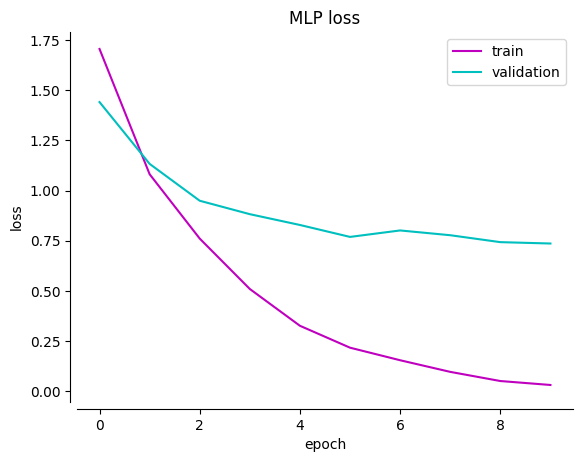

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'], color='m')
plt.plot(history.history['val_loss'], color='c')
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')

sns.despine(offset=5)

plt.show()

And now the same for the `accuracy`.

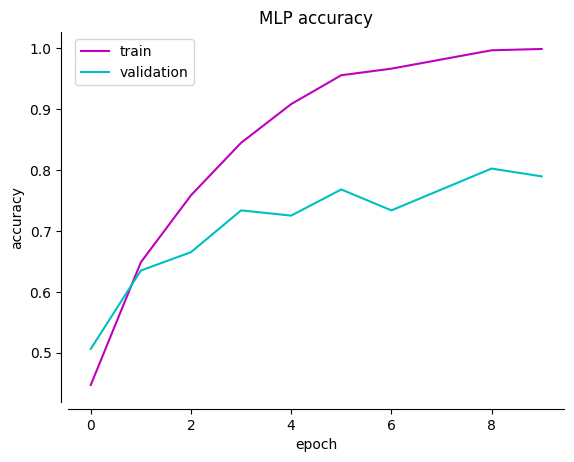

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'], color='m')
plt.plot(history.history['val_accuracy'], color='c')
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

sns.despine(offset=5)

plt.show()

`````{admonition} How would you interpret these plots...
:class: tip
concerning our `MLP`'s `learning process`? Does it make sense? If not, how should it look like? Could you use these plots to evaluate certain aspects of the `learning process`, e.g. `regularization`?
`````

## Assessing performance

After evaluating the `training` of our `MLP`, we of course also need to evaluate its (`predictive`) `performance`. Here, this refers to the `accuracy` of our `MLP`'s outcomes, ie its `predictions`. We already saw this in the above plots and during the `training` across `epochs` but let's check the `accuracy` of the `prediction` on the `training set` again:

In [15]:
from sklearn.metrics import classification_report
y_train_pred = model_mlp.predict(X_train)
print(classification_report(y_train.values.argmax(axis = 1), y_train_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91        85
           1       0.97      0.98      0.97        88
           2       0.97      0.92      0.94        90
           3       0.97      0.96      0.97        81
           4       1.00      0.96      0.98        91
           5       0.98      0.98      0.98       471
           6       0.90      0.94      0.92        81
           7       0.98      0.96      0.97        90
           8       0.91      0.87      0.89        84

    accuracy                           0.96      1161
   macro avg       0.95      0.95      0.95      1161
weighted avg       0.96      0.96      0.96      1161



Why you might think: "Oh, that's awesome, great performance.", such outcomes are usually perceived as dangerously high and indicate that something is off... 

`````{admonition} Why should a close-to-perfect performance indicate that something is wrong?
:class: tip
What do you think is the rationale to say that very high `scores` are actually "suspicious" and tells us that something is most likely wrong? Try thinking about the things you've learned so far: `training`/`test`/`validation` `datasets` and their size, `models`, `predictions`, etc. . 
`````


Luckily, we did `split` our `dataset` into **independent** `training` and `test` `sets`. So, let's check our `MLP`'s performance on the `test set`:

In [16]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.78      0.70      0.74        20
           2       0.55      0.67      0.60        18
           3       0.90      0.96      0.93        27
           4       0.88      0.88      0.88        17
           5       0.93      0.91      0.92       117
           6       0.64      0.67      0.65        27
           7       1.00      0.94      0.97        18
           8       0.67      0.50      0.57        24

    accuracy                           0.82       291
   macro avg       0.78      0.78      0.78       291
weighted avg       0.83      0.82      0.82       291



As you can see, the `scores`, ie `performance`, drops quite a bit. Do you know why and which you would report, e.g. in a `publication`?

Beside checking the overall `scores`, there are other options to further evaluate our `MLP`'s (or basically any other model's) `performance`. One of the most commonly used ones is called `confusion matrix` (which you most likely have seen before in this course). A `confusion matrix` displays how often a given `sample` was `predicted` as a certain `label`, thus, for example, providing insights into differentiability, etc. . To implement this, we initially have to compute the `confusion matrix`:

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1))
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

After that, we can `plot` it for evaluation.

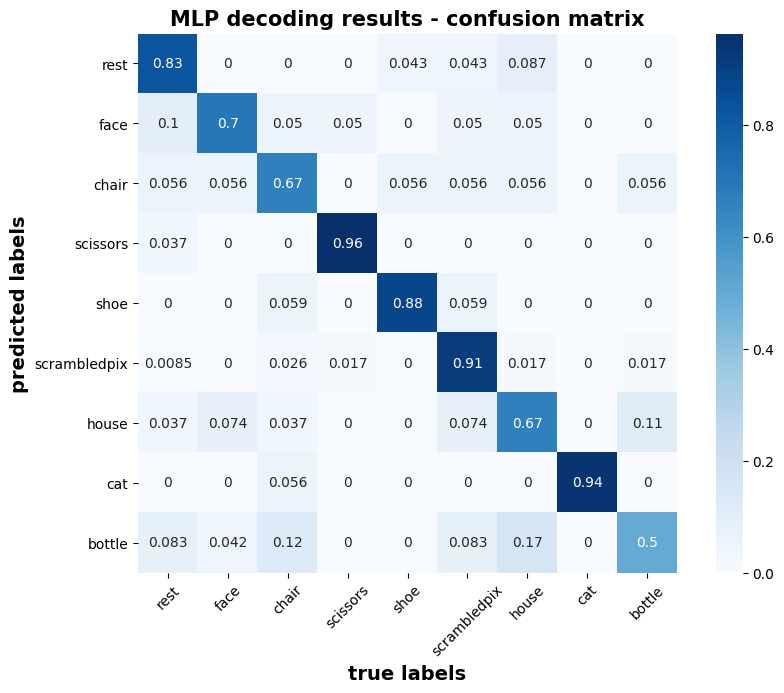

In [18]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(model_conf_matrix, index = categories,
                     columns = categories)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True, cmap = 'Blues', square = True)
plt.xticks(rotation = 45)
plt.title('MLP decoding results - confusion matrix' , fontsize = 15, fontweight = 'bold')
plt.xlabel("true labels", fontsize = 14, fontweight = 'bold')
plt.ylabel("predicted labels", fontsize = 14, fontweight = 'bold')
plt.show()

Based on this outcome: how would you interpret the `confusion matrix`? Are some `categories` better `"decodable"` than others? Could even make such a statement?

## Summary

With that, we already reached the end of this `tutorial` within which we talked about how to `create`, `train` and `evaluate` a `MLP` as one possible `decoding model` that can be applied to `brain data`. As mentioned before, the `MLP` utilized here is rather simple and `models` you see (and maybe use) out in the "real world" will most likely be way more complex. However, their application to `brain data` concerning `input`, `hidden` and `output layers` follows the same outline.

```{tip}
Unfortunately, visualizing the features/transformations of an `ANN` is quite often not straightforward as it depends on the given `ANN` architecture. However, you can check this fantastic 
[distill article](https://distill.pub/2017/feature-visualization/) to learn more about `feature visualization` in `artificial neural networks`.
```

## Exercises
 * What is the most difficult category to decode? Why?
 * The model seemed to overfit. Try adding a `Dropout` layer to regularize the model. You can read about dropout in keras in this [blog post](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab).
 * Try to add layers or hidden units, and observe the impact on overfitting and training time.